# Importy

In [1]:
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt

___
# Funkcja wykorzystana w zadaniach

In [2]:
def autokowariancja_emp(h, x_trajectory):
    n = len(x_trajectory)
    x_mean = np.mean(x_trajectory)
 
    x = x_trajectory[:n - h]
    x_h = x_trajectory[h:]
 
    return (1 / n) * np.sum((x - x_mean) * (x_h - x_mean))

___
# Zadanie 1

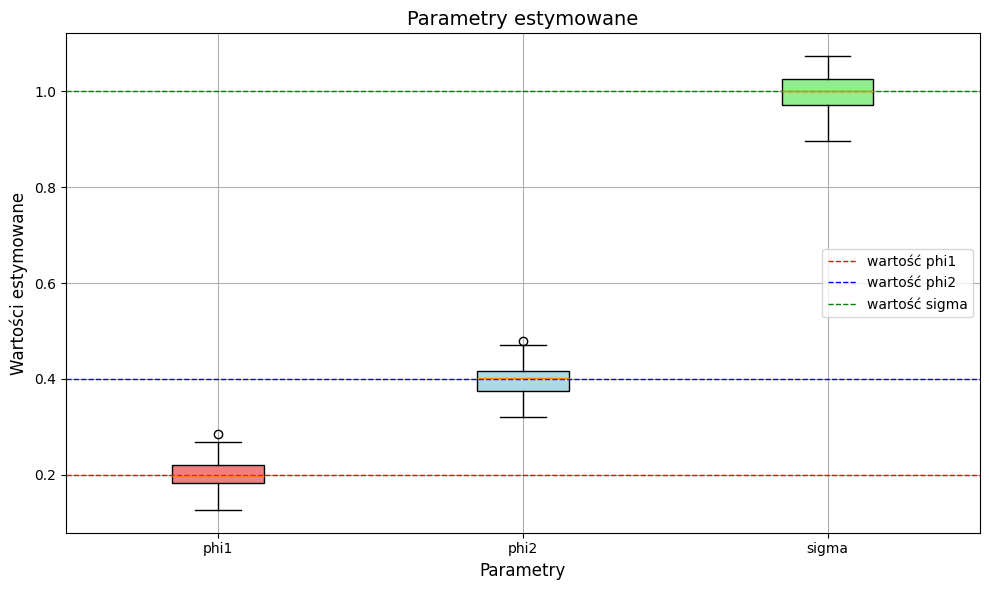

In [11]:
def simulate_AR2(phi1, phi2, sigma, n = 1000):

    ar = np.array([1, -phi1, -phi2])  
    ma = np.array([1])  
    ar_process = ArmaProcess(ar=ar, ma=ma)
    return ar_process.generate_sample(nsample=n, scale=np.sqrt(sigma))

def parametry(trajectory, p_value):
    gamma = np.array([autokowariancja_emp(p, trajectory) for p in range(1, p_value+1)])
    Gamma_matrix = np.zeros((p_value, p_value))
    
    for i in range(p_value):
        for j in range(p_value):
            Gamma_matrix[i, j] = autokowariancja_emp(abs(i-j), trajectory)  

    phi_hat = np.matmul(np.linalg.inv(Gamma_matrix), gamma)

    sigma_hat = autokowariancja_emp(0, trajectory) - np.matmul(np.transpose(phi_hat), gamma)
    
    return phi_hat, sigma_hat

phi1 = 0.2
phi2 = 0.4
sigma = 1

phi1_hats = []
phi2_hats = []
sigma_hats = []

for i in range(100):
    simulated_data = simulate_AR2(phi1, phi2, sigma)
    phi_params, sigma_params = parametry(simulated_data, 2)
    phi1_hats.append(phi_params[0])
    phi2_hats.append(phi_params[1])
    sigma_hats.append(sigma_params)

plt.figure(figsize=(10,6))
box = plt.boxplot([phi1_hats, phi2_hats, sigma_hats],
                  patch_artist=True,
                  tick_labels=['phi1', 'phi2', 'sigma'])

colors = ['lightcoral', 'lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.axhline(phi1, color='red', linestyle='--', linewidth=1, label='wartość phi1')
plt.axhline(phi2, color='blue', linestyle='--', linewidth=1, label='wartość phi2')
plt.axhline(sigma, color='green', linestyle='--', linewidth=1, label='wartość sigma')
plt.title('Parametry estymowane', fontsize=14)
plt.xlabel('Parametry', fontsize=12)
plt.ylabel('Wartości estymowane', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

___
# Zadanie 2

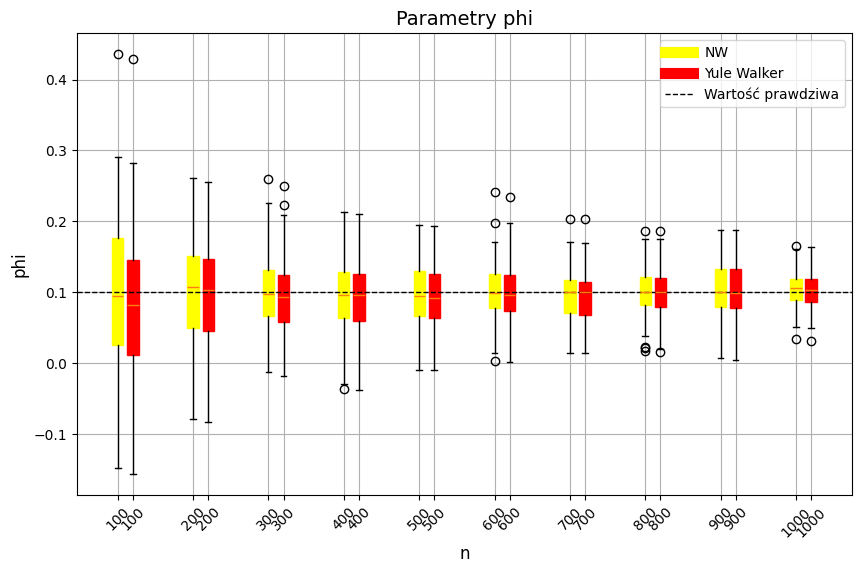

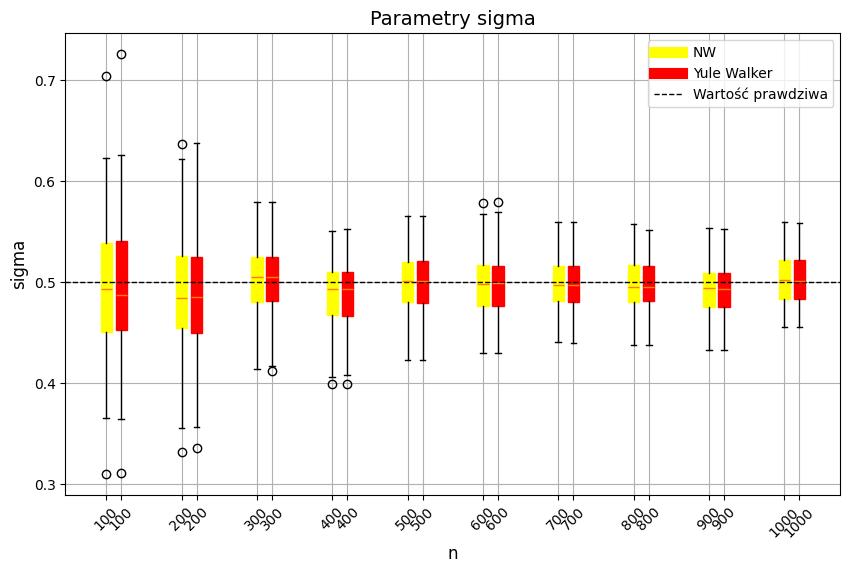

In [14]:
def simulate_AR1(phi1, sigma, n = 1000):

    ar = np.array([1, -phi1])  
    ma = np.array([1])  
    ar_process = ArmaProcess(ar=ar, ma=ma)
    return ar_process.generate_sample(nsample=n, scale=np.sqrt(sigma))

def phi_nw(x):
    x_lag = x[:-1]
    x = x[1:]
    return np.sum(x * x_lag)/np.sum(x_lag**2)


def sigma_nw(x):
    n = len(x)
    x_lag = x[:-1]
    x = x[1:]      
    phi_hat = phi_nw(x) 
    sigma_hat = np.sum((x - phi_hat * x_lag)**2) / n  
    return sigma_hat


def parametry(trajectory, p_value):
    gamma = np.array([autokowariancja_emp(p, trajectory) for p in range(1, p_value+1)])
    Gamma_matrix = np.zeros((p_value, p_value))
    
    for i in range(p_value):
        for j in range(p_value):
            Gamma_matrix[i, j] = autokowariancja_emp(abs(i-j), trajectory)  

    phi_hat = np.matmul(np.linalg.inv(Gamma_matrix), gamma)

    sigma_hat = autokowariancja_emp(0, trajectory) - np.matmul(np.transpose(phi_hat), gamma)
    
    return phi_hat, sigma_hat

phi = 0.1
sigma = 0.5
n_values = np.arange(100,1100,100)
M = 100

phi_nw_results = []
sigma_nw_results = []
phi_yw_results = []
sigma_yw_results = []

for n in n_values:
    phi_nw_hats = []
    sigma_nw_hats = []
    phi_yw_hats = []
    sigma_yw_hats = []

    for _ in range(M):
        ar1 = simulate_AR1(phi, sigma, n)
        phi_nw_hats.append(phi_nw(ar1))
        sigma_nw_hats.append(sigma_nw(ar1))

        parametry_yw = parametry(ar1, 1)

        phi_yw_hats.append(parametry_yw[0][0])
        sigma_yw_hats.append(parametry_yw[1])
    phi_nw_results.append(phi_nw_hats)
    sigma_nw_results.append(sigma_nw_hats)
    phi_yw_results.append(phi_yw_hats)
    sigma_yw_results.append(sigma_yw_hats)


plt.figure(figsize=(10,6))
b1 = plt.boxplot(phi_nw_results, 
                 tick_labels=n_values, 
                 positions=np.arange(100, 1100, 100)-10, 
                 widths=15,
                 patch_artist=True, 
                 boxprops=dict(facecolor='yellow', color='yellow'))
b2 = plt.boxplot(phi_yw_results, 
                 tick_labels=n_values, 
                 positions=np.arange(100, 1100, 100)+10, 
                 widths=15,
                 patch_artist=True, 
                 boxprops=dict(facecolor='red', color='red'))

ref_line = plt.axhline(phi, color='black', linestyle='--', linewidth=1)

yellow_patch = plt.Line2D([0], [0], color='yellow', lw=8, label='NW')
red_patch = plt.Line2D([0], [0], color='red', lw=8, label='Yule Walker')
line_patch = plt.Line2D([0], [0], color='black', lw=1, linestyle='--', label='Wartość prawdziwa')

plt.legend(handles=[yellow_patch, red_patch, line_patch])
plt.title('Parametry phi', fontsize=14)
plt.xlabel('n', fontsize=12)
plt.ylabel('phi', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
b3 = plt.boxplot(sigma_nw_results, 
                 tick_labels=n_values, 
                 positions=np.arange(100, 1100, 100)-10, 
                 widths=15,
                 patch_artist=True, 
                 boxprops=dict(facecolor='yellow', color='yellow'))
b4 = plt.boxplot(sigma_yw_results, 
                 tick_labels=n_values, 
                 positions=np.arange(100, 1100, 100)+10, 
                 widths=15,
                 patch_artist=True, 
                 boxprops=dict(facecolor='red', color='red'))

plt.axhline(sigma, color='black', linestyle='--', linewidth=1)

plt.legend(handles=[yellow_patch, red_patch, line_patch])
plt.title('Parametry sigma', fontsize=14)
plt.xlabel('n', fontsize=12)
plt.ylabel('sigma', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

___
# Zadanie 5

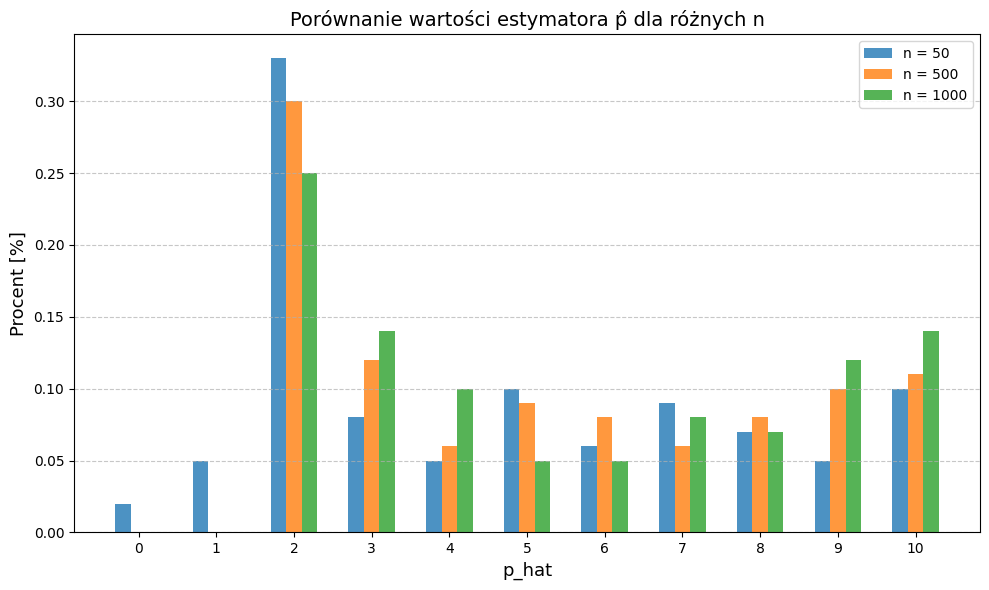

In [ ]:
def fpe(x, p):
    n = len(x)
    sigma = parametry(x, p)[1]
    return (sigma**2) * (n + p) / (n - p)

phi1 = 0.2
phi2 = 0.4
sigma = 1
n_values = [50, 500, 1000]
p_values = np.arange(0, 11) 


results = {n: {p: 0 for p in p_values} for n in n_values}

for n in n_values:
    p_hat_count = {p: 0 for p in p_values}  
    for _ in range(100):  
        ar2 = simulate_AR2(phi1, phi2, sigma, n)
        fpes = [fpe(ar2, p) for p in p_values]  
        p_hat = np.argmin(fpes)  
        p_hat_count[p_hat] += 1 

    for p in p_values:
        results[n][p] = p_hat_count[p] / 100 

plt.figure(figsize=(10, 6))
x_pos = np.arange(len(p_values))

bar_width = 0.2
opacity = 0.8

for idx, n in enumerate(n_values):
    plt.bar(x_pos + idx * bar_width, 
            [results[n][p] for p in p_values], 
            bar_width,
            alpha=opacity, 
            label=f'n = {n}')

plt.xlabel('p_hat', fontsize=13)
plt.ylabel('Procent [%]', fontsize=13)
plt.title('Porównanie wartości estymatora p̂ dla różnych n', fontsize=14)
plt.xticks(x_pos + bar_width * (len(n_values) - 1) / 2, p_values)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()